# Uncertainty Quantification for Stellar Population-Kinematic Models of Galaxies

In [13]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src as uq4pk

## Overview

A galaxy's light is dominated by its stars. We can measure several properties of stars from their spectra: intrinsic ones, such as their ages and chemical compositions as well as extrinsic ones, such as their velocities. Our goal is to learn about the distribution of stellar properties within a galaxy. This has important implications for understanding the physics of star formation, galaxy formation, as well as cosmological questions such as the nature of dark matter.

Our inverse problem is to decompose a galaxy spectrum into constituent parts representing the different populations of stars with different velocity signatures. This problem is formally stated in the [forward model section](#forwardmod). The preceding sections introduce the necessary concepts, and throughout the notebook there are code demonstrations showing how to access and generate relevant quantities. The next sections describe current approaches to the [inverse problem](#inverseprob), and [nuisance effects](#nuisance). The final section describes current approaches to [uncertainty quantification](#uncertainty).

* [Stellar populations](#stellarpops)
* [Stellar kinematics](#stellarkins)
* [The forward model](#forwardmod)
* [The inverse problem: regularisation and sparsity](#inverseprob)
* [Nuisance effects](#nuisance)
* [Uncertainty quantification](#uncertainty)

<a id='stellarpops'></a>

## Stellar populations

For all but the most nearby galaxies in the Universe, we cannot resolve individual stars. Instead we observe the integrated light of an unresolved population. The concept of a stellar population is physically meaningful: stars form in groups from a parent gas cloud. Stars within a group share properties, such as their age and chemical composition. When modeling stellar content of galaxies, it therefore makes sense to use the "stellar population" as a building-block, rather than individual stars. The [MILES simple stellar population models (SSPs)](http://miles.iac.es/pages/ssp-models.php) are a tabulated set of such models.

The SSPs are stored in a matrix $X$. It can be accessed as 

In [2]:
ssps = uq4pk.model_grids.MilesSSP()
print('number of SSP templates = ', ssps.p)
print('number of wavelength bins per template = ', ssps.n)
print('dims(X) = ', ssps.X.shape)

number of SSP templates =  636
number of wavelength bins per template =  2000
dims(X) =  (2000, 636)


The 636 SSP models are sampled from an underlying parameter grid with the following properties

In [3]:
print('number of parameters = ', ssps.npars)
print('grid size = ', ssps.par_dims)
print('description of paramters:')
for i in range(ssps.npars): print(ssps.par_string[i])

number of parameters =  2
grid size =  (12, 53)
description of paramters:
1) metallicity of stellar population
2) age of stellar population


Metallicity measures the ratio of metal abundance to hydrogen abundance. It is given in logarithmic units relative to solar - [Z/H] - such that a [Z/H]=0 is the solar ratio, [Z/H]=1 is 10 times more metal abundant than the sun etc. The age is in Gyr.

Let's look at the spectrum for a particular SSP model and print it's parameters

plotting SSP # 60
with metallicity  -1.8350000000000002 [Z/H]
with age 0.11 Gyr


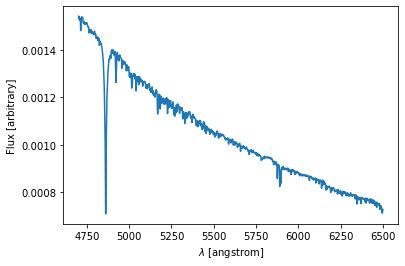

In [4]:
idx = 60

print('plotting SSP #', idx)
print('with metallicity ', ssps.pars[0][idx], '[Z/H]')
print('with age', ssps.pars[1][idx], 'Gyr')
plt.plot(ssps.lmd, ssps.X[:,idx])
_ = plt.gca().set_xlabel('$\lambda$ [angstrom]')
_ = plt.gca().set_ylabel('Flux [arbitrary]')

We can also compare several SSP models side by side. There is a special plotting routine for this. Rather than view all 636 models, let's just take every 15th age and every 5th metallicity. We also restrict the wavelength range, and - in order that all models are visible on the same y-scale - we column normalise the SSP matrix.

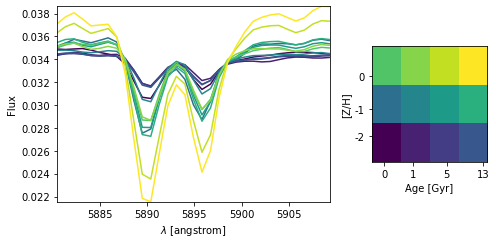

In [5]:
ssps = uq4pk.model_grids.MilesSSP(thin_age=15, 
                                  thin_z=5, 
                                  normalise_models='column',
                                  lmd_min=5880,
                                  lmd_max=5910)
plotter = uq4pk.plotting.Plotter(ssps=ssps)
plotter.plot_ssps()

This double absorption line is the sodium doublet. Stellar populations with greater metallicity have deeper absorption lines.

Next let's focus on a different wavelength range,

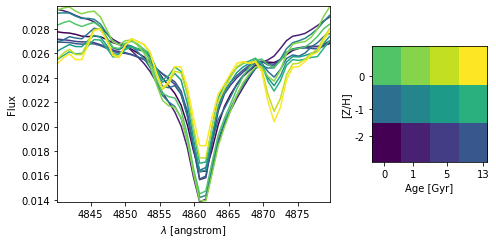

In [6]:
ssps = uq4pk.model_grids.MilesSSP(thin_age=15, 
                                  thin_z=5, 
                                  normalise_models='column',
                                  lmd_min=4840,
                                  lmd_max=4880)
plotter = uq4pk.plotting.Plotter(ssps=ssps)
plotter.plot_ssps()

This is the H$\beta$ hydrogen absorption line. It's shape depends on the age of the stellar population. In addition to absorption lines, the shape and normalisation of the spectral continuum also encode information about stellar populations.

<a id='stellarkins'></a>

## Stellar kinematics

The Doppler effect will cause the observed spectrum to be shifted from its rest wavelength. Approaching/receding material is shifted to shorter/longer wavelengths, respectively. Not all stars move with the same velocity, however. There is a distribution of velocities, and the rest-wavelength galaxy spectrum is convolved by this distribution before reaching the observer. We want to measure this distribution.

Doppler broadening is only sensitive to the component of velocity along the line-of-sight (LOS). Therefore the distribution of interest is the line-of-sight velocity distribution (LOSVD). An initial step in our analysis is to estimate the galaxy's systemic LOS velocity and shift the spectrum by this amount. In practice, this means that we can assume the LOSVD is approximately centered around zero.

The gravitational potentials of galaxies can host a complex zoo of stellar orbits. LOSVDs can therefore also be complex, and modern spectroscopic instruments have sufficient resolution to capture these complexities. Numerical orbit integration is needed to generate physical models of the LOSVD. For our current tests, however, it will be sufficient to assume a parameterised form. Here we generate some random mock LOSVDs using Gaussian Mixture Models (GMMs),

Text(0, 0.5, 'pdf')

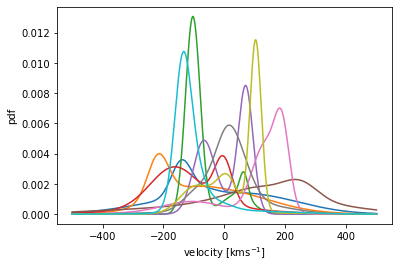

In [7]:
v = np.linspace(-500, 500, 1000)
for i in range(10):
    losvd = uq4pk.losvds.InputLOSVD()
    plt.plot(v, losvd.evaluate(v))
plt.gca().set_xlabel('velocity [kms$^{-1}$]')
plt.gca().set_ylabel('pdf')

GMMs are convenient parameterisations for generating LOSVDs. The input parameters for sampling GMMs have been chosen to roughly reproduce the levels of complexity and diversity we expect to see in real LOSVDs. Whilst we will use GMMs to generate mock data, we do not use GMMs when modelling observed data.

The Gauss-Hermite (GH) expansion has the become standard LOSVD parameterisation to model observed data. This is defined as

$$
L(v ; \theta_v) = \mathcal{N}(\hat{v};0,1^2) \left[\sum_{m=0}^{M} h_m H_m(\hat{v})\right]
$$

$$
\hat{v} = \frac{v - V}{\sigma}
$$

with parameters

$$
\theta_v = (V, \sigma, h_0, ..., h_M).
$$

where the expansion order $M$ is fixed in advance. The $H_m$ are Hermite polynomials with the normalisation 

$$
H_m(x) = \frac{H_m^\mathrm{phys}(x)}{\sqrt{m! 2^m}}
$$

where $H_m^\mathrm{phys}$ are the conventionally defined *physicists' Hermite polynomials*. $\mathcal{N}(x;0,1^2)$ is the standard normal pdf.

Here I'll demonstrate code to calculate the GH expansion of an LOSVD evaluated at discrete velocities. For this example I fix values of the parameters $V$ and $\sigma$, which makes optimising the $h_m$ simple. For real analyses, we do not fix $V$ or $\sigma$.

Expansion co-efficients:
h_0 = 0.026616677217312767
h_1 = -0.012573793534648952
h_2 = 0.003361061946461161
h_3 = 0.006830577173737258
h_4 = 0.0025168614408171332
h_5 = -0.004928001876594321
h_6 = 0.005006591711933901


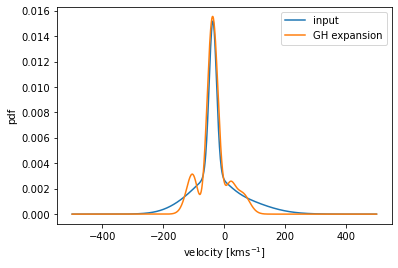

In [8]:
np.random.seed(301288)

# generate a random input LOSVD
losvd = uq4pk.losvds.InputLOSVD()

# evaluate LOSVD and store arrays in a histogram object
v_edg = np.linspace(-500, 500, 1000)
v = (v_edg[1:] + v_edg[:-1])/2.
v_hist = uq4pk.losvds.Histogram(xedg=v_edg,
                                y=losvd.evaluate(v))

# fit a GH expansion for given values of M, V, sigma
M = 6
V = -20
sigma = 30
gh = uq4pk.losvds.GaussHermite()
h = gh.get_gh_expansion_coefficients(v_mu=V,
                                     v_sig=sigma,
                                     vel_hist=v_hist,
                                     max_order=M)
print('Expansion co-efficients:')
for i in range(M+1):
    print(f'h_{i} = {h[i]}')

# evaluate the GH expansion
gh_losvd = gh.evaluate(v, V, sigma, h)

# fit a GH expansion for given values of M, V, sigma
_ = plt.plot(v_hist.x, v_hist.y, label='input')
_ = plt.plot(v, gh_losvd, label='GH expansion')
_ = plt.legend()
_ = plt.gca().set_xlabel('velocity [kms$^{-1}$]')
_ = plt.gca().set_ylabel('pdf')

The GH-expansion has some nice properties which have made it the standard choice. However, it has several shortcomings including that normalisation is unconstrained and positivity cannot be ensured. These would be desirable properties as the LOSVD should properly be defined as a probability distribution.

For these reasons amongst others we are looking into alternatives to the GH expansions. If there is a reason to replace them in order to implement your method, we would therefore be open to this option. If there is no such reason, I recommend that we stick with to GH expansions for backward-compatibility.

<a id='forwardmod'></a>

## The forward model

We can now describe the forward model. 

The spectrum of a stellar population with parameters

$$\theta_s = (\mathrm{metallicity}, \mathrm{age})$$

is notated by

$$s(\lambda;\theta_s).$$

A GH LOSVD with parameters

$$\theta_v = (V, \sigma, h_0, ..., h_M)$$

is notated by

$$L(v;\theta_v).$$

There is a distribution functon 

$$f_s(\theta_s)$$

describing the distribution of stellar populations in the galaxy. It is normalised as

$$
f_s(\theta_s) \ge 0 \;\;\;\;\; \int f_s(\theta_s) \; \mathrm{d}\theta_s = \mathrm{total}
$$

where "total" is the total stellar content of the galaxy in the same units as the SSP models e.g. total stellar mass or luminosity. The composite spectrum of all stellar population in the galaxy is given by

\begin{equation*}
S(\lambda; f_s) = \int f_s(\theta_s) s(\lambda;\theta_s) \; \mathrm{d}\theta_s .
\label{eq:S_composite_spectrum} \tag{1} 
\end{equation*}

Our signal is the composite spectrum convolved with the LOSVD

\begin{equation*}
\bar{y}(\lambda) =  \int^{\infty}_{-\infty} \frac{1}{1+v/c} S\left(\frac{\lambda}{1+v/c}; f_s\right) L(v;\theta_v) \; \mathrm{d}v
\label{eq:ybar} \tag{2}
\end{equation*}

where the factors of $(1+v/c)$ perform the Doppler shifting, and $c$ is the speed of light.

The observed spectrum is given by passing this signal through some transfer function $T$ encoding nuisance effects, and the addition of noise $\epsilon$,

$$y(\lambda) = T[\bar{y}(\lambda)] + \epsilon$$

The goal is to infer $f_s$ and $\theta_v$ from data $y$.

The next sections discuss the inverse problem and nuisance effects in more detail. Before that, I'll demonstrate code for generating a signal $\bar{y}(\lambda)$ given an input $f_s(\theta_s)$ and LOSVD.

We first generate the population distribution function, $f_s(\theta_s)$. We again generate these as GMMs, now in the 2D space of $\theta_s=$(age, metallicity). These are not - even approximately - realistic physical models, but should be sufficient for testing recovery algorithms. Let's look at an example

In [9]:
# re-generate the ssp grid
# using realistic wavelength range 
# and normalise such that each ssp model has equal flux
ssps = uq4pk.model_grids.MilesSSP(normalise_models='column')

# create a random distribution function for this grid of ssp models
np.random.seed(21453)
df = uq4pk.distribution_function.DistributionFunction(ssps)

The distribution function can be accessed in two ways: as a 1D array $\beta$ or reconstructed into a 2D array representing the underlying geometry of the parameter space $\theta_s$,

1D flattened DF has dimensions: (636,)
2D grid DF has dimensions: (12, 53)


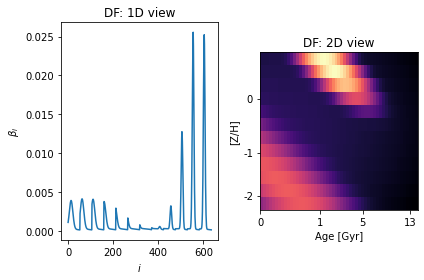

In [10]:
print('1D flattened DF has dimensions:', df.beta.shape)  # ... or as a flattened array
print('2D grid DF has dimensions:', df.F.shape)          # accessible in grid form...

# visualise the distribution function
fig, ax = plt.subplots(1, 2)
plotter.ssps = ssps # plotting routine needs access to the ssps...
plotter.df = df     # ... and the df
_ = ax[0].plot(df.beta)
ax[0].set_title('DF: 1D view')
ax[0].set_xlabel('$i$')
ax[0].set_ylabel('$\\beta_i$')
_ = plotter.plot_df(ax=ax[1], view='true')
ax[1].set_title('DF: 2D view')
fig.tight_layout()
plt.show()

Using the vectorised distribution function $\beta$ and the matrix $X$ storing the SSP models, the discretised version of equation (1) reads

\begin{equation*}
S(\lambda; \beta) = X \beta
\label{eq:composite_spec_linear} \tag{3}
\end{equation*}

which is then convolved with an LOSVD according to equation (2),

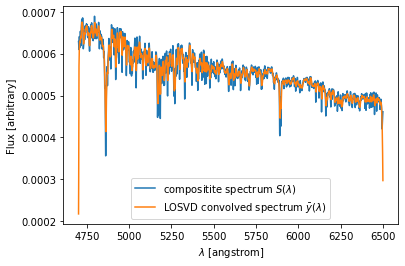

In [11]:
# get composite spectrum
S = np.dot(ssps.X, df.beta)

# generate a random input LOSVD to convolve with spectrum
losvd = uq4pk.losvds.InputLOSVD()
ybar = losvd.convolve(S=S, lmd_in=ssps.lmd)

# plot
_ = plt.plot(ssps.lmd, S, label='compositite spectrum $S(\lambda)$')
_ = plt.plot(ssps.lmd, ybar, label='LOSVD convolved spectrum $\\bar{y}(\lambda)$')
_ = plt.gca().set_xlabel('$\lambda$ [angstrom]')
_ = plt.gca().set_ylabel('Flux [arbitrary]')
_ = plt.gca().legend()
_ = plt.show()

In reality this ideal signal will be distorted by nuissance effects. These are discussed [below](#nuissance) however for now we will ignore them, and assume that our observed data is simply this signal with added noise. Noise is modelled as Gaussian, independent per wavelength bin, with variance parameterised via a signal-to-noise ratio (SNR) per wavelength bin, where typical datasets have SNR in the range 30-300.

The following convenience function generates noisy mock data for a randomly generated population distribution and LOSVD, at a given SNR,

The population DF is stored as <uq4pk_src.distribution_function.DistributionFunction object at 0x118d4fb70>
The LOSVD is stoered as <uq4pk_src.losvds.InputLOSVD object at 0x118d322e8>


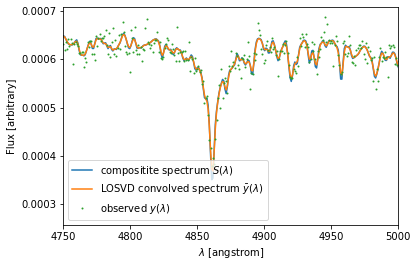

In [14]:
mock_data = uq4pk.data.RandomMockData(ssps=ssps, snr=30)

print('The population DF is stored as', mock_data.df)
print('The LOSVD is stoered as', mock_data.losvd)

_ = plt.plot(mock_data.lmd, mock_data.S, label='compositite spectrum $S(\lambda)$')
_ = plt.plot(mock_data.lmd, mock_data.ybar, label='LOSVD convolved spectrum $\\bar{y}(\lambda)$')
_ = plt.plot(mock_data.lmd, mock_data.y, 'o', ms=1, label='observed $y(\lambda)$')
_ = plt.gca().set_xlabel('$\lambda$ [angstrom]')
_ = plt.gca().set_ylabel('Flux [arbitrary]')
_ = plt.gca().legend()
_ = plt.gca().set_xlim(4750, 5000) # restrict wavelength range for visibility
_ = plt.show()

## The inverse problem: regularisation/sparsity

The physics of galaxy formation provides several motivating considerations for tackling the inverse problem. We expect population distributions to be mixtures of components, where individual components are smooth, and the space between components is relatively empty. We expect LOSVDs to be somewhat smooth. This section describes these choices in more detail.

Firstly, we expect population distributions to be smooth because of the continuous enrichment of gas from stellar evolution. Nuclear fusion within stars produces metals, which can pollute surrounding gas, from which the subsequent population of stars form. Viewed on resolvable-timescales, this  produces a smooth distribution of stellar ages and metallicites. Current implementations promote smoothness using second and/or third order finite difference regularisers in the (2D) space of population ages and metallicities.

The basic picture is complicated by mergers and accretion. As a galaxy evolves, it may merge with satellite galaxies. This motivates our expectation that population distributions can be thought of as a mixture, where each mixture component will represenent a merged satellite galaxy. Different satellites occupy different regions of parameter space, with the intervening regions empty. No current implementation to the problem - as far as we are aware - promote this sparsity, however we believe it may prove useful.

Lastly, we expect some degree of regularity in the LOSVD. Current implementations impose this by promoting Gaussianity, which - using the GH parameterisation introduced above - amounts to including a regulariser of the form 

$$\sum_{i=3}^M h_i^2$$

where the $h_i$ are Gauss Hermite expansion co-efficients. The motivation for this choice is not that we believe that real LOSVDs to be Gaussian, but to drive solutions to a simple form in the limit of low quality data. In reality, LOSVDs will be more complex than Gaussian, though we still would expect that they have a degree of smoothness.

An alternative approach to the current implementation would be to make the notion of a mixture model explicit. This would mean replacing equation (2) with

\begin{equation*}
\bar{y}(\lambda) = \int^{\infty}_{-\infty} \frac{1}{1+v/c} 
    \sum_{i=1}^{N_\mathrm{cmp}} \left[ 
    S\left(\frac{\lambda}{1+v/c}; f_s^i\right) L(v;\theta_v^i) 
    \right] \;\mathrm{d}v
\label{eq:alt_mod}
\end{equation*}

i.e. a sum over components, where each component has its own population distribution $f_s^i(\theta_s)$ and its own LOSVD parameterised by $\theta_v^i$. A benefit to this approach is that the per-component LOSVDs may indeed be well-described by Gaussians, with the complexity of the combined LOSVD arising from the superposition of a few distinct components. There has been some recent success using models such as equation (3), but it is a relatively experimental approach.

<a id='nuisance'></a>

## Nuisance effects

Our signal of interest is distorted by many effects before being observed. We'll call these nuisance effects. The content in this section probably goes beyond what is necessary for initial algorithm testing, but I include it here to foreshadow extra hurdles that will arise when modelling real data.

There are a variety of different nuisance effects. Some are astronomical e.g.

* the effect of dust absorption in the galaxy
* emission from ionised gas in the galaxy
* emission from the sky

and some instrumental, e.g.

* convolution with the line spread function (LSF, i.e the instruments wavelength resolution)
* inaccuracies in the flux calibration
* inaccuracies in the wavelength calibration

For real data analysis, some of these effects are modelled (gas emision) and some masked out of the data (wavelengths severely affected by sky emision). Convolution with the LSF is dealt with by pre-convolving the stellar population templates by an LSF model. Remaining effects are modelled-away by multiplication by and addition of polynomials

$$T[\bar{y}(\lambda)] = \bar{y}(\lambda) \mathcal{P}(\lambda) + \mathcal{Q}(\lambda)$$

where $\mathcal{P}(\lambda)$ and $\mathcal{Q}(\lambda)$ are of the form

$$\mathcal{P}(\lambda) = \sum_{k=1}^{P} p_k \mathcal{L}_k(\lambda)$$

$$\mathcal{Q}(\lambda) = \sum_{k=1}^{Q} q_k \mathcal{L}_k(\lambda)$$

where $\mathcal{L}_k$ are Legendre polynomials, $P$ and $Q$ are fixed (with typical, and ad-hoc, choices in the range 4-16), and the coefficients $p_k$ and $q_k$ are free parameters. As well as modelling-away systematic effects listed above, the use of multiplicative/additive polynomials will also mask-over inaccuracies in our physical models (e.g. in the adopted set of stellar population templates) ensuring a good quality-of-fit.

The current practice for this type of model is to perform the analysis in two independent steps: firstly to extract the population distribution, secondly to extract kinematics. For the first step, only a multiplicative polynomial $\mathcal{P}(\lambda)$ will be used. This is because additive polynomials can easily change the relative strength of spectral features, which can heavily impact the derived population distributions. For the kinematic-extraction step, both multiplicative $\mathcal{P}(\lambda)$ and additive $\mathcal{Q}(\lambda)$ polynomials will be used, the thinking being that kinematics are less degenerate with $\mathcal{Q}(\lambda)$. As an added complexity, often a different set of stellar population templates will be used in each step.

<a id='uncertainty'></a>

## Uncertainty Quantification

The current best-practice for uncertainty estimation is Monte-Carlo re-sampling of the data. This is unsatisfactory as it can be slow, and misses a possibly large chunk of the uncertainty budget: uncertainty in the regularisation parameters. Currently, regularisation parameters are chosen using some data-driven method (e.g. L-curve, a $\Delta \chi^2$ criterion, or cross-validation) but uncertainties in this choice are not folded through.

We have recently developed one approach to this problem using Hamiltonian Monte-Carlo (HMC) sampling. To make this computationally feasible, we do not use the matrix of SSP templates $X$ which consists of several hundred close-to co-linear columns. Instead, we replace this with a matrix of the first few (5-20) principal components (PCs) of $X$. We can then use HMC to sample the posterior defined by the forward model and suitable smoothing priors on the LOSVD. As a final step, we deproject posterior samples in the PC-space to the original space of stellar-population templates. This recent development is being refined and tested, but has produced some promising early results.

There is a need for more approaches to uncertainty quantification for this problem. The HMC approach must to be assessed against alternatives, and - regardless of the outcome - is likely to be too cumbersome for the typical astronomer's analysis pipelines. Similarly, there is a broader problem, where we consider *spatial* in addition to spectral data. The increase in the size of the dataset for the broader problem will necessitate more lightweight approaches than HMC.